# 3 Numerical Application: Generation of Efficient Frontier

# Environment

I am using Python here because only Python, R, and Matlab are allowed.

## Imports

In [44]:
import yfinance as yf
import polars as pl
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

# 1.

Download data.

In [19]:
tickers = ["META", "AMZN", "AAPL", "NFLX", "GOOG"]
start = "2022-01-01"
end = "2024-12-31"

data = yf.download(tickers, start=start, end=end)["Close"]
data

[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOG,META,NFLX
Date,,,,,
2022-01-03,178.879898,170.404495,144.555084,337.251709,597.369995
2022-01-04,176.609650,167.522003,143.899460,335.249359,591.150024
2022-01-05,171.911865,164.356995,137.160675,322.936432,567.520020
2022-01-06,169.042068,163.253998,137.058533,331.194855,553.289978
2022-01-07,169.209137,162.554001,136.513992,330.527435,541.059998
...,...,...,...,...,...
2024-12-23,254.989655,225.059998,195.990005,599.849976,911.450012
2024-12-24,257.916443,229.050003,197.570007,607.750000,932.119995
2024-12-26,258.735504,227.050003,197.100006,603.349976,924.140015


Convert to Polars DataFrame.

In [20]:
df = pl.from_pandas(data.reset_index())
df = df.rename({"Date": "date"})
df

date,AAPL,AMZN,GOOG,META,NFLX
datetime[ns],f64,f64,f64,f64,f64
2022-01-03 00:00:00,178.879898,170.404495,144.555084,337.251709,597.369995
2022-01-04 00:00:00,176.60965,167.522003,143.89946,335.249359,591.150024
2022-01-05 00:00:00,171.911865,164.356995,137.160675,322.936432,567.52002
2022-01-06 00:00:00,169.042068,163.253998,137.058533,331.194855,553.289978
2022-01-07 00:00:00,169.209137,162.554001,136.513992,330.527435,541.059998
…,…,…,…,…,…
2024-12-23 00:00:00,254.989655,225.059998,195.990005,599.849976,911.450012
2024-12-24 00:00:00,257.916443,229.050003,197.570007,607.75,932.119995
2024-12-26 00:00:00,258.735504,227.050003,197.100006,603.349976,924.140015


# 2.

Compute daily and annualized return.

In [25]:
returns_df = (
    df.with_columns(
        [(pl.col(ticker) / pl.col(ticker).shift(1) - 1).alias(f"{ticker}_daily_return") for ticker in tickers]
    )
    .drop_nulls()
    .with_columns(
        [(pl.col(f"{ticker}_daily_return") * 252).alias(f"{ticker}_annualized_return") for ticker in tickers]
    )

)
returns_df

date,AAPL,AMZN,GOOG,META,NFLX,META_daily_return,AMZN_daily_return,AAPL_daily_return,NFLX_daily_return,GOOG_daily_return,META_annualized_return,AMZN_annualized_return,AAPL_annualized_return,NFLX_annualized_return,GOOG_annualized_return
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-01-04 00:00:00,176.60965,167.522003,143.89946,335.249359,591.150024,-0.005937,-0.016916,-0.012691,-0.010412,-0.004535,-1.496189,-4.262728,-3.19825,-2.623889,-1.142937
2022-01-05 00:00:00,171.911865,164.356995,137.160675,322.936432,567.52002,-0.036728,-0.018893,-0.0266,-0.039973,-0.04683,-9.255372,-4.761059,-6.703154,-10.073181,-11.801113
2022-01-06 00:00:00,169.042068,163.253998,137.058533,331.194855,553.289978,0.025573,-0.006711,-0.016693,-0.025074,-0.000745,6.444372,-1.691167,-4.206742,-6.318668,-0.187662
2022-01-07 00:00:00,169.209137,162.554001,136.513992,330.527435,541.059998,-0.002015,-0.004288,0.000988,-0.022104,-0.003973,-0.507827,-1.08052,0.249058,-5.570235,-1.001209
2022-01-10 00:00:00,169.228806,161.485992,138.077866,326.821564,539.849976,-0.011212,-0.00657,0.000116,-0.002236,0.011456,-2.825422,-1.655684,0.029292,-0.563571,2.886855
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-12-23 00:00:00,254.989655,225.059998,195.990005,599.849976,911.450012,0.024947,0.000622,0.003065,0.00264,0.015703,6.286534,0.156855,0.772369,0.665317,3.957088
2024-12-24 00:00:00,257.916443,229.050003,197.570007,607.75,932.119995,0.01317,0.017729,0.011478,0.022678,0.008062,3.31884,4.467615,2.892473,5.714889,2.031535
2024-12-26 00:00:00,258.735504,227.050003,197.100006,603.349976,924.140015,-0.00724,-0.008732,0.003176,-0.008561,-0.002379,-1.824445,-2.200393,0.800273,-2.157399,-0.599485


# 3.

Compute expected returns vector $\mu$.

In [26]:
mu = (
    returns_df.select([pl.col(f"{ticker}_annualized_return").mean().alias(f"{ticker}_mean") for ticker in tickers])
    .to_numpy()
    .flatten()
)
mu

array([0.30920058, 0.16117727, 0.15153147, 0.26472372, 0.15015158])

Compute covariance matrix $\Sigma$.

In [27]:
annualized_returns_np = returns_df.select([pl.col(f"{ticker}_annualized_return") for ticker in tickers]).to_numpy()
Sigma = np.cov(annualized_returns_np, rowvar=False)
Sigma

array([[59.89081909, 28.2131141 , 16.73612824, 28.90034123, 24.09146925],
       [28.2131141 , 37.06979297, 14.75868059, 24.01321127, 20.68442646],
       [16.73612824, 14.75868059, 18.51798169, 14.96888643, 13.90722188],
       [28.90034123, 24.01321127, 14.96888643, 60.69335964, 17.16245177],
       [24.09146925, 20.68442646, 13.90722188, 17.16245177, 27.07180831]])

# 4.

Create $\Lambda$ from 0 to 0.5.

In [56]:
Lambda = np.arange(0.001, 0.501, 0.001)
Lambda[:5]

array([0.001, 0.002, 0.003, 0.004, 0.005])

# 5.

Optimize the minimum of the function $-(\mu^T w - \tfrac{\lambda_t}{2} \cdot w^T \Sigma w)$ i.e. the maximum of $\mu^T w - \tfrac{\lambda_t}{2} \cdot w^T \Sigma w$

In [47]:
def portfolio_optimization(lambda_t: float):    
    def objective(w):
        return -(mu @ w - (lambda_t / 2) * w.T @ Sigma @ w)
    
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(None, None)] * len(tickers)
    w0 = np.ones(len(tickers)) / len(tickers)
    
    result = opt.minimize(objective, w0, constraints=constraints, bounds=bounds)
    return result.x if result.success else None

Compute the optimal portfolios for each $\lambda_t$.

In [54]:
optimal_portfolios = {lambda_t: portfolio_optimization(lambda_t) for lambda_t in Lambda}

optimal_portfolios[0.001]

array([ 4.13257389, -1.93778343, -0.8873206 ,  1.8536281 , -2.16109796])

Compute portfolio statistics for each $\lambda_t$.

In [49]:
portfolio_stats = []

for lambda_t in Lambda:
    w_opt = portfolio_optimization(lambda_t)
    if w_opt is not None:
        mu_p = mu @ w_opt
        sigma_p = np.sqrt(w_opt.T @ Sigma @ w_opt)
        portfolio_stats.append((lambda_t, mu_p, sigma_p))
stats_df = pl.DataFrame(
    {
        "Lambda": [x[0] for x in portfolio_stats],
        "Expected Return": [x[1] for x in portfolio_stats],
        "Expected Volatility": [x[2] for x in portfolio_stats],
        # "Portfolio Weights": [x[3].tolist() for x in portfolio_stats],
    }
)
stats_df

Lambda,Expected Return,Expected Volatility
f64,f64,f64
0.001,0.997218,29.453461
0.002,0.572003,15.155693
0.003,0.430282,10.563914
0.004,0.359428,8.382332
0.005,0.316968,7.15209
…,…,…
0.496,0.148526,4.13637
0.497,0.148523,4.136368
0.498,0.148519,4.136367


# 6.

Plot efficient frontier.

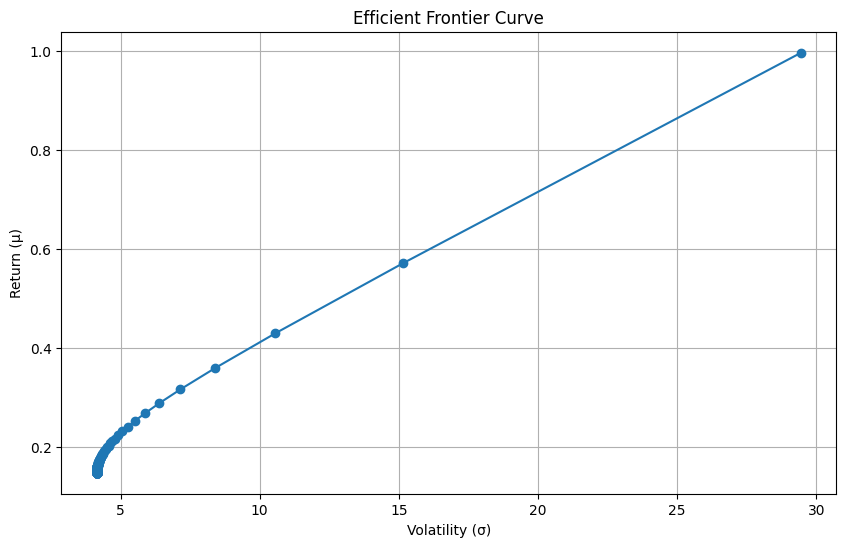

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(stats_df["Expected Volatility"], stats_df["Expected Return"], marker='o', linestyle='-', label='Efficient Frontier')
plt.xlabel("Volatility (σ)")
plt.ylabel("Return (μ)")
plt.title("Efficient Frontier Curve")
plt.grid(True)
plt.show()

The shape is similar to that of the square root curve, which then levels out into a linear function.